# Dataset
Download data from:  
https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz - **This is a CIFAR-10 version for python**

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
%matplotlib inline

In [60]:
import tensorflow as tf

In [1]:
# your data path
CIFAR_PATH = 'data/'

In [2]:
# unpickle data
def unpickle(file):
    with open(file, 'rb') as f:
        cifar_dict = pickle.load(f, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [10]:
all_data = {}
for dir in dirs:
    file_path = os.path.join(CIFAR_PATH, dir)
    all_data[dir] = unpickle(file_path)

In [14]:
all_data['batches.meta']

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [15]:
all_data['data_batch_1'].keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

Loaded in this way, each of the batch files contains a dictionary with the following elements:

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

In [18]:
x = all_data['data_batch_1'][b'data']

(10000, 3072)

In [23]:
x = x.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype(np.uint8)
x[0].shape

(32, 32, 3)

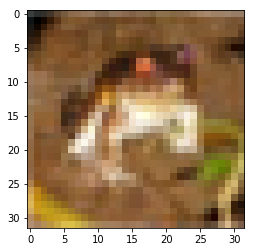

In [24]:
plt.imshow(x[0])

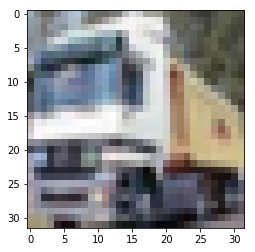

In [25]:
plt.imshow(x[1])

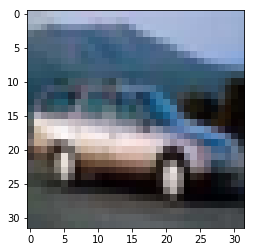

In [28]:
plt.imshow(x[4])

# Dealing with data functions

In [29]:
def one_hot_encode(vec, vals=10):
    # 10 possible labels
    num_of_labels = len(vec)
    labels_mtx = np.zeros(shape=(num_of_labels, vals))
    labels_mtx[range(num_of_labels), vec] = 1
    return labels_mtx

In [42]:
data = [batch_data for key, batch_data in all_data.items() if 'data_batch_' in key]
test_batch = all_data['test_batch']

In [87]:
class DataHelper():
    def __init__(self, data, test_batch):
        self.curr_pos = 0
        self.data = data
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_imgs = None
        self.training_labels = None
        
        self.test_imgs = None
        self.test_labels = None
    
    def set_up_images(self):
        def reshape_and_normalize(images):
            imgs_len = images.shape[0]
            images = images.reshape(imgs_len, 3, 32, 32).transpose(0, 2, 3, 1) / 255
            return images
        
        print("Setting up training images and labels")
        
        # training images
        training_imgs = np.vstack([d_set[b'data'] for d_set in self.data])
        self.train_length = training_imgs.shape[0]
        self.training_imgs = reshape_and_normalize(training_imgs)
        train_labels = np.hstack([d_set[b'labels'] for d_set in self.data])
        self.training_labels = one_hot_encode(vec=train_labels, vals=10)
        
        print("Setting up test images and labels")
        
        # test imges
        test_imgs = np.vstack([d_set[b'data'] for d_set in self.test_batch])
        self.test_imgs = reshape_and_normalize(test_imgs)
        test_labels = np.hstack([d_set[b'labels'] for d_set in self.test_batch])
        self.test_labels = one_hot_encode(vec=test_labels, vals=10)
        
    def next_batch(self, batch_size):
        x = self.training_imgs[self.curr_pos:(self.curr_pos + batch_size)].reshape(batch_size, 32, 32, 3)
        y = self.training_labels[self.curr_pos:(self.curr_pos + batch_size)]
        self.curr_pos = (self.curr_pos + batch_size) % self.train_length
        return x, y
    
    def get_test_images(self):
        return self.test_imgs
    def get_test_labels(self):
        return self.test_labels

# Create Data Helper and set up images

In [88]:
data_helper = DataHelper(data=data, test_batch=test_batch)
data_helper.set_up_images()

Setting up training images and labels
Setting up test images and labels


# Create placeholders

In [61]:
images = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
labels = tf.placeholder(dtype=tf.float32, shape=[None, 10])
hold_prob = tf.placeholder(dtype=tf.float32)

# Create network functions

In [62]:
def init_weights(shape):
    random_weights = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(random_weights)

In [64]:
def init_bias(shape):
    bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(bias_vals)

In [65]:
def conv_2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [72]:
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [75]:
def convolution_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv_2d(input_x, W) + b)

In [69]:
def fully_connected(input_x, size):
    input_size = int(input_x.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_x, W) + b

# Create a network

In [76]:
# Create convolution layer
conv_1 = convolution_layer(images, shape=[4, 4, 3, 32]) # filter wight, height, input channels, output channels
pool_1 = max_pool(conv_1)
conv_2 = convolution_layer(pool_1, shape=[4, 4, 32, 64])
pool_2 = max_pool(conv_2)

In [78]:
# reshape for fully_connected
pool_2 = tf.reshape(pool_2, shape=[-1, 8*8*64])

In [79]:
# Create fully connected layer
fully_conn_3 = tf.nn.relu(fully_connected(pool_2, size=512))
drop_3 = tf.nn.dropout(fully_conn_3, keep_prob=hold_prob)
labels_pred = fully_connected(drop_3, size=10)

# Loss function

In [80]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=labels_pred))

# Optimizer

In [82]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

# Initialize variables

In [83]:
init_vars = tf.global_variables_initializer()

In [92]:
steps = 1000
with tf.Session() as sess:
    sess.run(init_vars)
    
    for step in range(steps):
        batch_size = 100
        batch_images, batch_labels = data_helper.next_batch(batch_size)
        
        sess.run(
            train, feed_dict = {
                images: batch_images,
                labels: batch_labels,
                hold_prob: 0.5
            }
        )
        
        if step % 100 == 0:
            print('Current step: {}'.format(step))
            matches = tf.equal(tf.argmax(labels, axis=1), tf.argmax(labels_pred, axis=1))
            matches = tf.cast(matches, tf.float32)
            accuracy = tf.reduce_mean(matches)
            accuracy_result = sess.run(accuracy, feed_dict={
                images: data_helper.get_test_images(),
                labels: data_helper.get_test_labels(),
                hold_prob: 1.0
            })
            print('Accuracy: {}'.format(round(accuracy_result, 2)))
            print('\n')
            

Current step: 0
Accuracy: 0.07999999821186066


Current step: 100
Accuracy: 0.30000001192092896


Current step: 200
Accuracy: 0.36000001430511475


Current step: 300
Accuracy: 0.38999998569488525


Current step: 400
Accuracy: 0.4300000071525574


Current step: 500
Accuracy: 0.4399999976158142


Current step: 600
Accuracy: 0.46000000834465027


Current step: 700
Accuracy: 0.4699999988079071


Current step: 800
Accuracy: 0.49000000953674316


Current step: 900
Accuracy: 0.5




# Discussion
After running the model for 900 steps we were able to obtain the accuracy of 50%. This result is promissing and the similar works showed that after 5000 loops the result should be around 70%